In [2]:
pip install cleanvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 3.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
fold_info = pd.read_csv("/kaggle/input/breakhis/Folds.csv")
fold_info["label"] = fold_info["filename"].str.extract("(malignant|benign)")
fold_info.head()

,fold,mag,grp,filename,label
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign


In [4]:

selected_mag =200
selected_mag_data = fold_info.query("mag == @selected_mag")\
                              .copy().reset_index(drop=True)
selected_mag_data["filename"] = ("/kaggle/input/breakhis/BreaKHis_v1/"
                                  + selected_mag_data["filename"])

In [5]:

train = selected_mag_data.query("grp == 'train'")
test = selected_mag_data.query("grp == 'test'")
train.shape, test.shape

((6616, 5), (3449, 5))

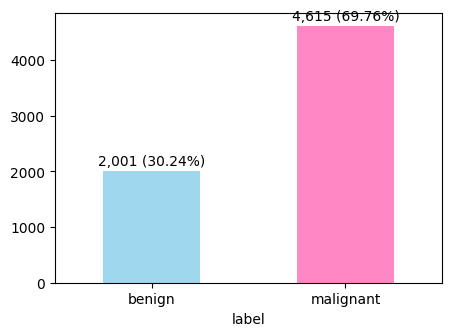

In [6]:
classes = dict(benign=0, malignant=1)
class_names = list(classes.keys())
label_counts = train["label"].value_counts(ascending=True)
ax = label_counts.plot.bar(color=["skyblue", "hotpink"], alpha=0.8,
                           figsize=(5, 3.5))
ax.bar_label(ax.containers[0], padding=2,
             labels=[f"{x:,} ({x/len(train):.2%})" for x in label_counts])
ax.set_xticklabels(["benign", "malignant"], rotation=0);


# Normalisation ,augmentation

In [7]:
from typing import Tuple
import tensorflow as tf
import cv2
import numpy as np

IMG_SIZE = 224
BATCH_SIZE = 16

def apply_clahe(image: tf.Tensor) -> tf.Tensor:
    """Apply CLAHE to enhance image contrast."""
    # Convert the image to numpy array (uint8) for CLAHE
    image_np = (image.numpy() * 255).astype(np.uint8)
    
    # Convert RGB to LAB for CLAHE
    lab_image = cv2.cvtColor(image_np, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab_image)
    
    # Apply CLAHE to the L-channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)
    
    # Merge and convert back to RGB
    lab_clahe = cv2.merge((l_clahe, a, b))
    image_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)
    
    # Convert back to Tensor and normalize to [0, 1]
    return tf.convert_to_tensor(image_clahe, dtype=tf.float32) / 255.0

def load_image(filename: str, label: int) -> Tuple[tf.Tensor, int]:
    file = tf.io.read_file(filename)
    img = tf.image.decode_png(file, channels=3)
    img = tf.image.resize_with_pad(img, IMG_SIZE, IMG_SIZE)
    
    # Data augmentation for label 0 (assuming label 0 corresponds to benign)
    if label == 0:  
        img = tf.image.random_flip_left_right(img)  # Horizontal flip
        img = tf.image.random_flip_up_down(img)  # Vertical flip
        img = tf.image.random_brightness(img, max_delta=0.1)  # Random brightness
        img = tf.image.random_contrast(img, lower=0.8, upper=1.2)  # Random contrast
        img = tf.image.random_saturation(img, lower=0.8, upper=1.2)  # Random saturation
        img = tf.image.random_crop(img, size=[IMG_SIZE, IMG_SIZE, 3])  # Random crop
    
    # Apply CLAHE
    img = tf.py_function(func=apply_clahe, inp=[img], Tout=tf.float32)
    img.set_shape([IMG_SIZE, IMG_SIZE, 3])  # Set shape explicitly

    # Optionally, add noise
    noise = tf.random.normal(shape=tf.shape(img), mean=0.0, stddev=0.1, dtype=tf.float32)
    img = img + noise  # Add noise
    img = tf.clip_by_value(img, 0.0, 1.0)  # Ensure values are within [0, 1]

    # Normalization
    img = (img - 0.5) / 0.5  # Normalize to [-1, 1]

    return img, label


In [8]:
from sklearn.model_selection import train_test_split
# Assuming train and test are DataFrames containing filenames and labels
SEED = 51432

train_ratio = 0.8  
valid_ratio = 0.2  
test_ratio = 0.2  

# Split the data into train and remaining data
X_train, X_remaining, y_train, y_remaining = train_test_split(
    train["filename"], train["label"].map(classes),
    train_size=train_ratio, stratify=train["label"].map(classes), random_state=SEED
)

# Split the remaining data into validation and test sets
X_valid, X_test, y_valid, y_test = train_test_split(
    X_remaining, y_remaining,
    test_size=test_ratio / (valid_ratio + test_ratio),
    stratify=y_remaining, random_state=SEED
)

# Prepare training dataset
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)) \
    .map(load_image).batch(BATCH_SIZE)

# Prepare validation dataset
validation_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid)) \
    .map(load_image).batch(BATCH_SIZE)

# Prepare test dataset
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)) \
    .map(load_image).batch(BATCH_SIZE)

In [9]:
pip install livelossplot

Note: you may need to restart the kernel to use updated packages.


Epoch 1/100
  1/331 ━━━━━━━━━━━━━━━━━━━━ 9:45:06 106s/step - AUC: 0.3333 - accuracy: 0.4375 - loss: 3.7713

W0000 00:00:1737914785.636156      81 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - AUC: 0.9850 - accuracy: 0.9668 - loss: 2.4665

W0000 00:00:1737914951.331965      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1737914964.045962      80 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


331/331 ━━━━━━━━━━━━━━━━━━━━ 286s 543ms/step - AUC: 0.9850 - accuracy: 0.9668 - loss: 2.4658 - val_AUC: 0.5000 - val_accuracy: 0.3021 - val_loss: 10.9658 - learning_rate: 1.0000e-04
Epoch 2/100
331/331 ━━━━━━━━━━━━━━━━━━━━ 124s 374ms/step - AUC: 0.9973 - accuracy: 0.9885 - loss: 1.6159 - val_AUC: 0.9423 - val_accuracy: 0.3021 - val_loss: 4.3688 - learning_rate: 1.0000e-04
Epoch 3/100
331/331 ━━━━━━━━━━━━━━━━━━━━ 123s 370ms/step - AUC: 0.9972 - accuracy: 0.9898 - loss: 1.0765 - val_AUC: 0.9994 - val_accuracy: 0.9970 - val_loss: 0.8894 - learning_rate: 1.0000e-04
Epoch 4/100
331/331 ━━━━━━━━━━━━━━━━━━━━ 123s 371ms/step - AUC: 0.9989 - accuracy: 0.9955 - loss: 0.7154 - val_AUC: 0.9762 - val_accuracy: 0.3082 - val_loss: 2.7746 - learning_rate: 1.0000e-04
Epoch 5/100
331/331 ━━━━━━━━━━━━━━━━━━━━ 124s 376ms/step - AUC: 0.9979 - accuracy: 0.9948 - loss: 0.4993 - val_AUC: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.3637 - learning_rate: 1.0000e-04
Epoch 6/100
331/331 ━━━━━━━━━━━━━━━━━━━━ 124s 

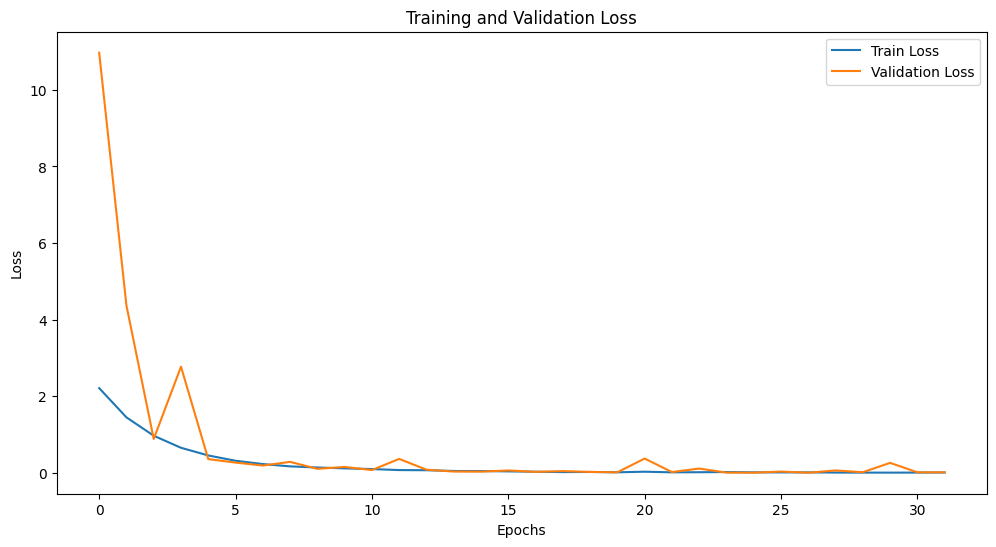

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import ResNet101
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Activation, Dropout, Conv2D, Multiply
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

EPOCHS = 100  
BATCH_SIZE = 16
INITIAL_LR = 0.0001

# Define the Residual CBAM module with dilated convolution
class ResidualCBAM(tf.keras.layers.Layer):
    def __init__(self, channel_axis=-1, reduction_ratio=16, **kwargs):
        super(ResidualCBAM, self).__init__(**kwargs)
        self.channel_axis = channel_axis
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        channels = input_shape[self.channel_axis]
        
        # Channel Attention
        self.channel_dense1 = Dense(channels // self.reduction_ratio, activation='relu')
        self.channel_dense2 = Dense(channels, activation='sigmoid')

        # Spatial Attention with dilated convolution
        self.conv1 = Conv2D(1, kernel_size=7, padding='same', dilation_rate=3, activation='sigmoid')

    def call(self, inputs):
        # Channel Attention
        avg_pool = tf.reduce_mean(inputs, axis=self.channel_axis, keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=self.channel_axis, keepdims=True)

        channel_attention = self.channel_dense1(avg_pool)
        channel_attention = self.channel_dense2(channel_attention)

        channel_attention = Multiply()([inputs, channel_attention])

        # Spatial Attention
        avg_pool_spatial = tf.reduce_mean(channel_attention, axis=self.channel_axis, keepdims=True)
        max_pool_spatial = tf.reduce_max(channel_attention, axis=self.channel_axis, keepdims=True)

        spatial_attention = tf.concat([avg_pool_spatial, max_pool_spatial], axis=-1)
        spatial_attention = self.conv1(spatial_attention)

        # Combine channel and spatial attention
        output = Multiply()([channel_attention, spatial_attention])

        # Residual connection: adding the original input back
        return inputs + output  # Residual connection

# Load the pre-trained ResNet101 model without the top layers
base_Neural_Net = ResNet101(input_shape=(224, 224, 3), weights='imagenet', include_top=False)




model = Sequential()
model.add(base_Neural_Net)  # Add base ResNet101
model.add(ResidualCBAM())  # Add Residual CBAM module
model.add(Flatten())  # Flatten the output
model.add(Dense(256, kernel_initializer='he_uniform'))  # Dense layer with He initialization
model.add(Dense(256, kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))  # ReLU activation
model.add(BatchNormalization())  # Batch normalization after activation
model.add(Dropout(0.6))  # Dropout to prevent overfitting
model.add(Dense(1, activation='sigmoid'))

# # Compile the model
# model = build_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'AUC']
)



# Early stopping based on validation loss
early_stopping_loss = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Early stopping based on validation accuracy
early_stopping_accuracy = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)


# Enhanced callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2, 
    patience=3,  
    min_lr=1e-7,
    verbose=1,
    cooldown=2 
)

# Modified threshold stopping with patience
class ThresholdStopping(tf.keras.callbacks.Callback):
    def __init__(self, accuracy_threshold=0.98, patience=5):
        super(ThresholdStopping, self).__init__()
        self.accuracy_threshold = accuracy_threshold
        self.patience = patience
        self.above_threshold = 0
        
    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get("val_accuracy")
        if val_accuracy is not None and val_accuracy >= self.accuracy_threshold:
            self.above_threshold += 1
            if self.above_threshold >= self.patience:
                print(f"\nMaintained {self.accuracy_threshold * 100}% validation accuracy for {self.patience} epochs. Stopping training.")
                self.model.stop_training = True
        else:
            self.above_threshold = 0

# Recompile model with modified learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR),
    loss='binary_crossentropy',
    metrics=['accuracy', 'AUC']
)

threshold_stopping = ThresholdStopping(accuracy_threshold=0.98, patience=5)

# Train with modified configuration
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=validation_ds,
    callbacks=[reduce_lr,early_stopping_loss],
    verbose=1
)
# Evaluate final accuracies
train_results = model.evaluate(train_ds)
val_results = model.evaluate(validation_ds)
test_results = model.evaluate(test_ds)  # Assuming test_ds is defined

# Extract and print specific metrics
train_loss, train_acc, train_auc = train_results
val_loss, val_acc, val_auc = val_results
test_loss, test_acc, test_auc = test_results

print(f"Final Train Accuracy: {train_acc:.5f}, AUC: {train_auc:.5f}")
print(f"Final Validation Accuracy: {val_acc:.5f}, AUC: {val_auc:.5f}")
print(f"Final Test Accuracy: {test_acc:.5f}, AUC: {test_auc:.5f}")

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix



# Loss plot
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 240ms/step


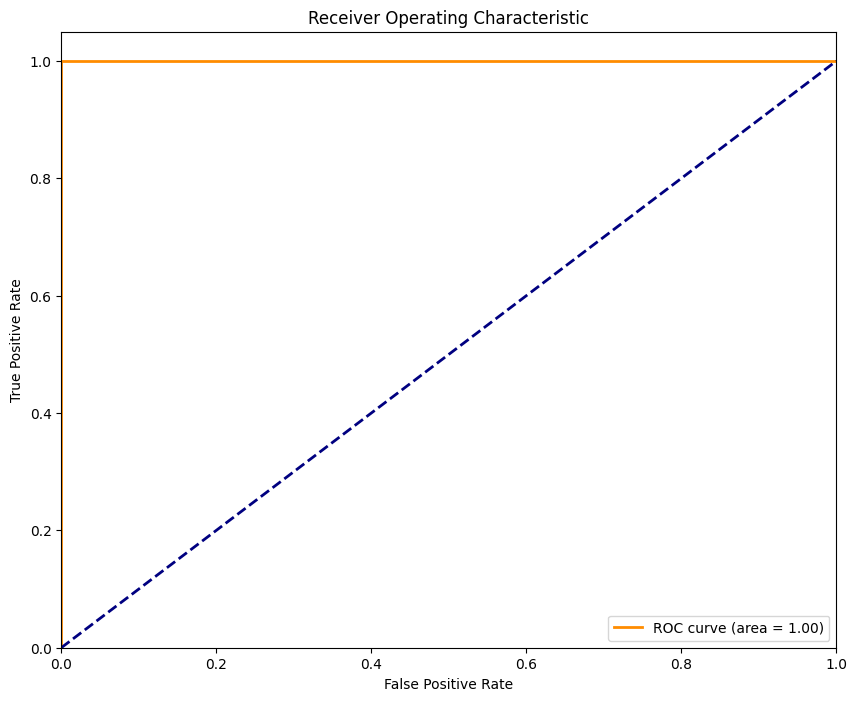

In [11]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities for the test set (not labels, but probabilities)
y_pred_prob = model.predict(test_ds)  # This will give probabilities between 0 and 1
y_true = np.concatenate([y for x, y in test_ds], axis=0)  # Get true labels from test_ds

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)  # fpr: false positive rate, tpr: true positive rate
roc_auc = auc(fpr, tpr)  # Calculate AUC

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line (random model)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 245ms/step


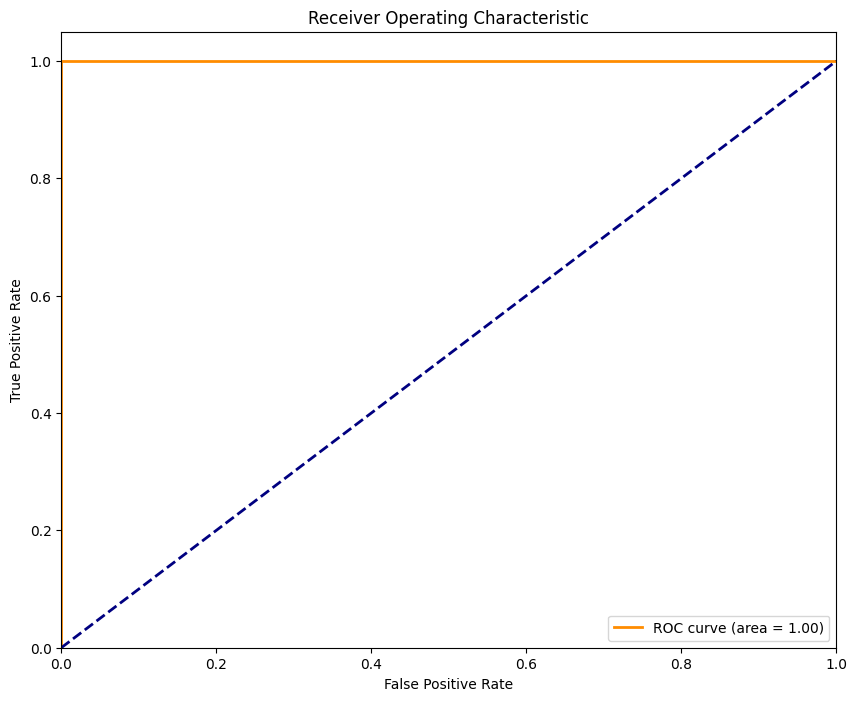

ROC curve saved as roc_curve.png


In [12]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np  # Ensure numpy is imported

# Get predicted probabilities for the test set (not labels, but probabilities)
y_pred_prob = model.predict(test_ds)  # This will give probabilities between 0 and 1
y_true = np.concatenate([y for x, y in test_ds], axis=0)  # Get true labels from test_ds

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)  # fpr: false positive rate, tpr: true positive rate
roc_auc = auc(fpr, tpr)  # Calculate AUC

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line (random model)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

# Save the plot as an image
filename = "roc_curve.png"  # You can change the file name and extension as needed
plt.savefig(filename, dpi=300, bbox_inches='tight')  # Save with high resolution

# Show the plot
plt.show()

print(f"ROC curve saved as {filename}")


In [13]:
# Additional Metrics 
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(y_true, y_pred_labels, target_names=['Class 0', 'Class 1']))


Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       200
     Class 1       1.00      1.00      1.00       462

    accuracy                           1.00       662
   macro avg       1.00      1.00      1.00       662
weighted avg       1.00      1.00      1.00       662

